# Re-Use this workflow on much bigger datset so tht neural nets are a more suitable tool

![image.png](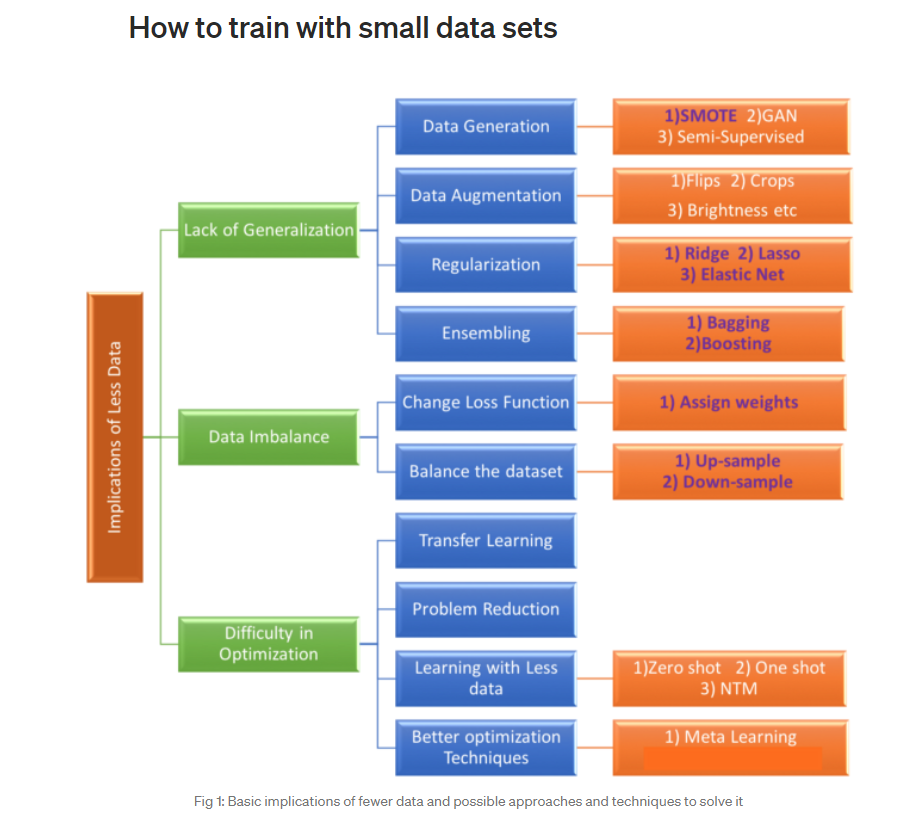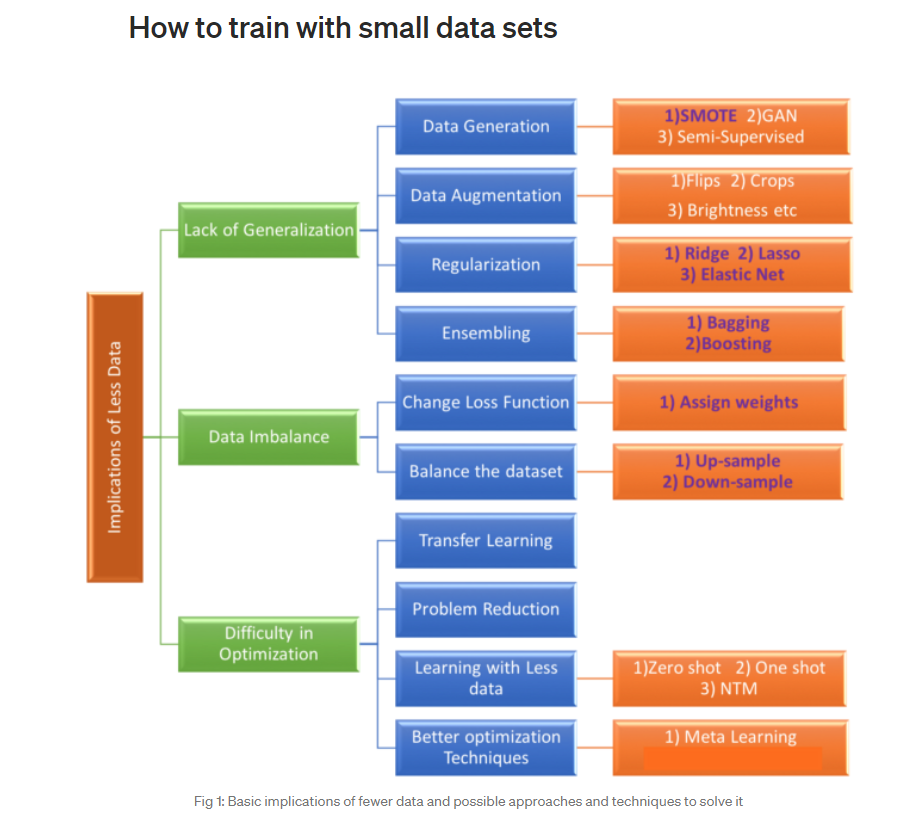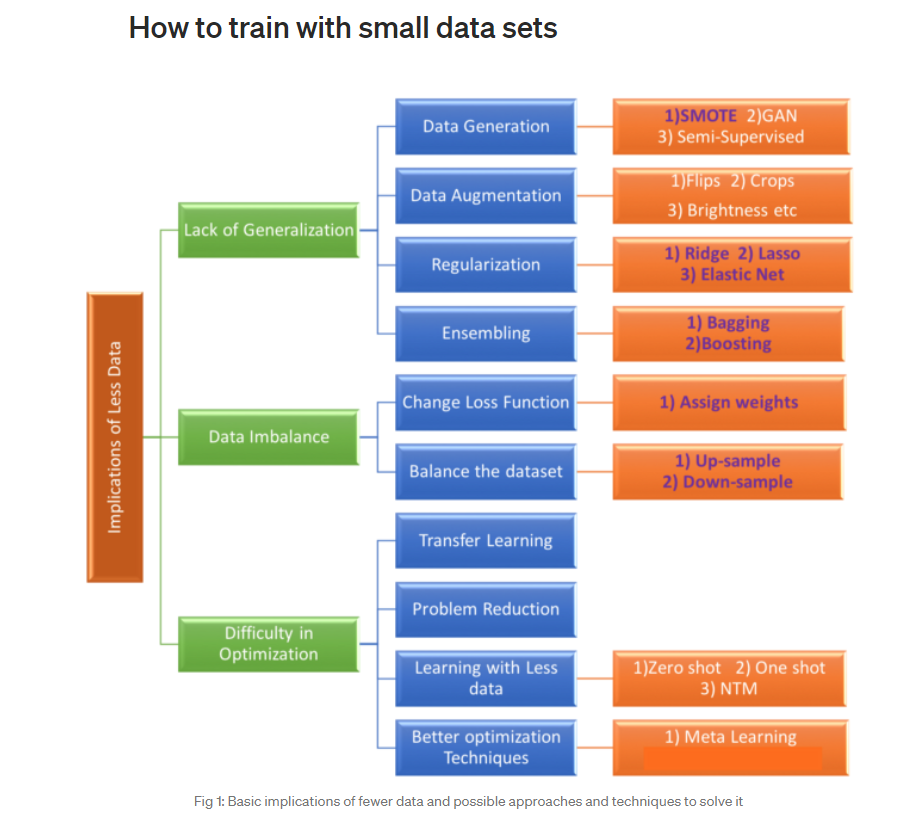)

In [ ]:
import requests
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
hungarian = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data")
switzerland = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data")
long_beach = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data")
cleveland = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data")

In [ ]:
complete_df = pd.DataFrame()
dfs = {} # for further reference
datasets = [hungarian,switzerland,long_beach,cleveland]
dataset_names = ['hungarian','switzerland','long_beach','cleveland']
for num, dataset in enumerate(datasets):
    dfs[num] = pd.DataFrame(list(map(lambda x: x.split(','), dataset.text.split('\n'))))
    print(len(dfs[num]))
    dfs[num]['region'] = dataset_names[num]
    complete_df = complete_df.append(dfs[num])
raw_df = complete_df
complete_df = complete_df.reset_index(drop=True) # prevents construction of an index column

295
124
201
304


In [ ]:
heart_disease_names = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names")

for counter, line in enumerate(heart_disease_names.text.split('\n')):
    print(counter, ' ', line)

0   Publication Request: 
1      >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2      This file describes the contents of the heart-disease directory.
3   
4      This directory contains 4 databases concerning heart disease diagnosis.
5      All attributes are numeric-valued.  The data was collected from the
6      four following locations:
7   
8        1. Cleveland Clinic Foundation (cleveland.data)
9        2. Hungarian Institute of Cardiology, Budapest (hungarian.data)
10        3. V.A. Medical Center, Long Beach, CA (long-beach-va.data)
11        4. University Hospital, Zurich, Switzerland (switzerland.data)
12   
13      Each database has the same instance format.  While the databases have 76
14      raw attributes, only 14 of them are actually used.  Thus I've taken the
15      liberty of making 2 copies of each database: one with all the attributes
16      and 1 with the 14 attributes actually used in past experiments.
17   
18      The authors of the d

In [ ]:
dirty_columns = heart_disease_names.text.split('\n')[110:124]
clean_columns = [''.join([letter for letter in word if letter.isalpha()]) for word in dirty_columns]
clean_columns[-1] = 'num'
complete_df.columns = clean_columns + ['region']

Column region could not be converted to float.


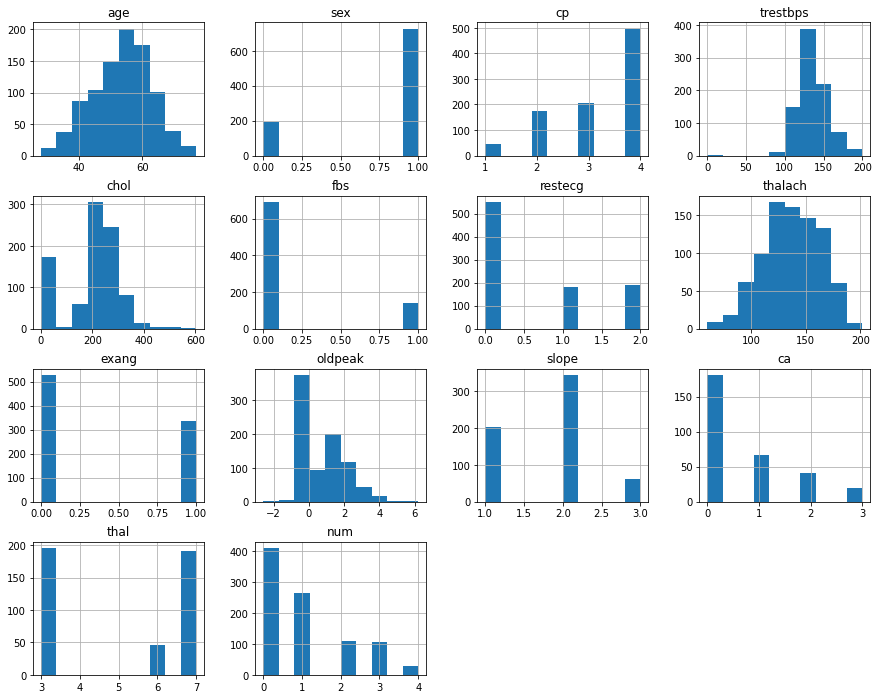

In [ ]:
complete_df = complete_df.applymap(lambda x: np.NaN if (x == '?' or x == '') else x)
complete_df = complete_df.iloc[0:-1] # last column was all Nones

# try to convert each column to int or float
for column in complete_df.columns:
    try:
        complete_df[column] = complete_df[column].astype(float)
    except Exception as e:
        print(f'Column {column} could not be converted to float.') # age had an empty string 

ax = complete_df.hist(figsize=(15,12))

In [ ]:
# Types
continuous_list = ['age','chol','oldpeak','thalach','trestbps'] 
nominals_list = ['ca', 'cp', 'restecg', 'slope', 'thal']
binomial_list = ['exang', 'fbs', 'sex']
target = 'num'

In [ ]:
missingness = (complete_df.isna().applymap(lambda x: 1 if x == True else 0).sum() / len(complete_df) ) * 100
missingness # use this instead of .info() because .info can miss the nulls if they're of the 'wrong' type

age          0.325027
sex          0.325027
cp           0.325027
trestbps     6.717226
chol         3.575298
fbs         10.075840
restecg      0.541712
thalach      6.283857
exang        6.283857
oldpeak      7.042254
slope       33.802817
ca          66.522210
thal        52.979415
num          0.325027
region       0.000000
dtype: float64

In [ ]:
feature_df = [column for column in complete_df.columns if column != 'num']
Y = complete_df['num']

In [ ]:
# To keep yourself entertained use a neural net to predict the missing values.
# Use an iterative approach e.g. start with data that has no nulls then move up the scale.
# This means that you're always relying more heavily on the more 'reliable' data and minimise the amount of data imputed based on synthetic data

no_nulls = complete_df.dropna(how='any')
print(f"Length with nulls = {len(complete_df)}. Length without nulls is {len(no_nulls)}")

Length with nulls = 923. Length without nulls is 299


In [ ]:
# This is a really awkward part of the API to use.
storage = {}
for num, nominal in enumerate(nominals_list):
  # this code is messy, fix it later
  unique_category_count = complete_df[nominals_list[num]].nunique()
  nominals_tensor = tf.convert_to_tensor(complete_df[nominals_list[num]], dtype='int64') # they're all already encoded as integers. But do require one-hot encoding nevertheless
  storage[num] = tf.one_hot(nominals_tensor, unique_category_count)

In [ ]:
nominals_tf = tf.concat(list(storage.values()), 1, name='concat') # have to be the same size in both dimensions? This seems ridiculous.

In [ ]:
print(complete_df['exang'].unique(), complete_df['fbs'].unique(), complete_df['sex'].unique())

[ 0.  1. nan] [ 0. nan  1.] [ 1.  0. nan]


In [ ]:
binomials_tf = tf.convert_to_tensor(complete_df[binomial_list],  dtype='float32')
continuous_tf = tf.convert_to_tensor(complete_df[continuous_list],  dtype='float32')
complete_tensor = tf.concat([nominals_tf, continuous_tf, binomials_tf], 1)

# remove rows where target (num) is nan
target_tf = tf.convert_to_tensor(Y)
non_null_target_idx = tf.where(~tf.math.is_nan(target_tf))
complete_tensor = tf.squeeze(tf.gather(complete_tensor, non_null_target_idx, axis=0))

null_targets = tf.where(tf.math.is_nan(target_tf))
target_tf = tf.squeeze(tf.gather(target_tf, non_null_target_idx, axis=0))
print(null_targets)

tf.Tensor(
[[294]
 [418]
 [619]], shape=(3, 1), dtype=int64)


In [ ]:
# Checking the binomials are properly encoded
# Need missingness by column
true_indices = tf.where(tf.math.is_nan(complete_tensor))
# Need to count by column (second number)
value, idx, number_nulls = tf.unique_with_counts(true_indices[:,1])

In [ ]:
print(value)
print(number_nulls)
# sort the first by the last (as a list??)

tf.Tensor([18 23 20 21 22 19], shape=(6,), dtype=int64)
tf.Tensor([30 90 55 59 55 62], shape=(6,), dtype=int32)


In [ ]:
values_nulls = zip(list(value.numpy()), list(number_nulls.numpy()))

columns_ordered = sorted(values_nulls, key = lambda x: x[1])
columns_ordered
# So use column 17 as target first not including any of the columns that have nulls
# lost of slicing required

[(18, 30), (20, 55), (22, 55), (21, 59), (19, 62), (23, 90)]

In [ ]:
columns_only = [column for column,number in columns_ordered]
columns_only

[18, 20, 22, 21, 19, 23]

In [ ]:
from tensorflow.python.keras import layers
from tensorflow.python import keras

In [ ]:
# np.array(complete_tensor)[:,columns_only]
#idx = list of coordinates of what you want to keep. Pretty awkward to use

#idx = tf.constant(columns_only, tf.int32)
#x = tf.gather_nd(complete_tensor, tf.stack([tf.range(complete_tensor.shape[0]), idx], axis=1))
complete_tensor.shape
feature_columns = [num for num in range(0,25) if num not in columns_only]
fancy_sliced = tf.gather(complete_tensor, feature_columns, axis=1)

from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

def build_and_compile_model(target_type, complexity = 'simple'):
  """ 
  Function to generate models
  May need to match the number of nodes to input / output in each layer??
  * Can have normalization as part of the model pipeline.
   """ 
  if complexity == 'simple':
    if target_type == 'binary':
      model = keras.Sequential(
        [ # what is the input layet?
            layers.Dense(10, activation="relu", name="layer1"),
            layers.Dense(30, activation="relu", name="layer2"),
            layers.Dense(1, activation='sigmoid', name="layer3"),
        ]
      )
      model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(0.001))

      return model

    if target_type == 'continuous':
      model = keras.Sequential(
        [ # what is the input layet?
            layers.Dense(10, activation="relu", name="layer1"),
            layers.Dense(30, activation="relu", name="layer2"),
            layers.Dense(1, name="layer3"), # no activation function!
        ]
      )
      model.compile(loss='mse',
                    optimizer=tf.keras.optimizers.Adam(0.001))
      return model

  if complexity == 'complex':
      if target_type == 'binary':
        model = keras.Sequential(
          [ # what is the input layet?
              layers.Dense(10, activation="relu", name="layer1"),
              layers.Dense(50, activation="relu", name="layer2"),
              layers.Dense(1, activation='sigmoid', name="layer4"),
          ]
        )
        model.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(0.001))

        return model


################ DEFINE YOUR CALLBACKS ############################

custom_early_stopping = EarlyStopping(
  monitor='val_loss', 
  min_delta=0.00001,
  patience=3)


def fit_model(model, x, y, epochs):
  """ Function to fit models """
  model.fit(
      X = x,
      Y = y,
      epochs=epochs,
      callbacks=[custom_early_stopping]
  )
  return model


def plot_learning(model, epochs):
  """ Plot learning curve for each model """
  print(f'Available data = {model.history.keys()}')
  train_loss = model.history['loss']
  val_loss = model.history['val_loss']
  x_range = range(0, len(train_loss))

  plt.plot(x_range, train_loss, label = "training loss")
  plt.plot(x_range, val_loss, label = "validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Metrics")
  plt.legend(loc="upper right")
  plt.show()

# Difference between Tensors and Sparse Tensors

The difference involves computational speed. If a large tensor has many, many zeroes, it's faster to perform computation by iterating through the non-zero elements. Therefore, you should store the data in a SparseTensor and use the special operations for SparseTensors.

Should check the distributions of the imputed values and non-null imputed values in each instance (bar chart of counts when binary). histogram / whisker plot otherwise.

Column is region. Count of nulls in column is 30
Feature columns are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 24]
Nulls in target = (30, 1). Should equal 30.
Nulls in training = (30, 1, 19). Should equal 30.
Target non_nulls = (890, 1). Correct shape.
Training non_nulls = (890, 1, 19). Correct shape.
non_null_training shape post squeeze = (890, 19)
non_null_target shape post squeeze = (890,).
null_training shape post squeeze = (30, 19).
null_target shape post squeeze = (30,).
Therefore type is continuous
Available data = dict_keys(['loss', 'val_loss'])


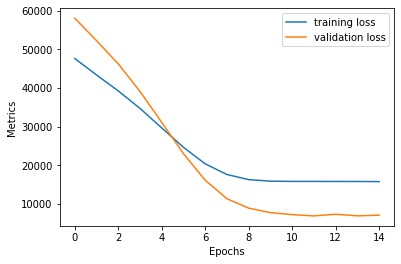

MODEL FIT SUCCESFULLY !! ??
Debugging shapes          (30,)          (30,)          [890   1]          (920,)
Debugging shapes
Imputed values (30, 1)
Target null (30, 1)
Non null targets (890, 1)
Full target vector (920, 1)
Non null target vector (890, 1)
FIRST ONE WORKED!!!
SECOND ONE WORKED!!!
Shape of resultant tensor (920, 20)
Column is region. Count of nulls in column is 55
Feature columns are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 24, 18]
Nulls in target = (55, 1). Should equal 55.
Nulls in training = (55, 1, 20). Should equal 55.
Target non_nulls = (865, 1). Correct shape.
Training non_nulls = (865, 1, 20). Correct shape.
non_null_training shape post squeeze = (865, 20)
non_null_target shape post squeeze = (865,).
null_training shape post squeeze = (55, 20).
null_target shape post squeeze = (55,).
Therefore type is continuous
Available data = dict_keys(['loss', 'val_loss'])


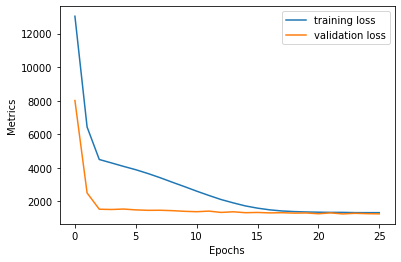

MODEL FIT SUCCESFULLY !! ??
Debugging shapes          (55,)          (55,)          [865   1]          (920,)
Debugging shapes
Imputed values (55, 1)
Target null (55, 1)
Non null targets (865, 1)
Full target vector (920, 1)
Non null target vector (865, 1)
FIRST ONE WORKED!!!
SECOND ONE WORKED!!!
Shape of resultant tensor (920, 21)
Column is region. Count of nulls in column is 55
Feature columns are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 24, 18, 20]
Nulls in target = (55, 1). Should equal 55.
Nulls in training = (55, 1, 21). Should equal 55.
Target non_nulls = (865, 1). Correct shape.
Training non_nulls = (865, 1, 21). Correct shape.
non_null_training shape post squeeze = (865, 21)
non_null_target shape post squeeze = (865,).
null_training shape post squeeze = (55, 21).
null_target shape post squeeze = (55,).
Therefore type is binary
Available data = dict_keys(['loss', 'val_loss'])


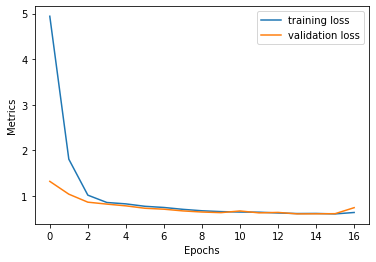

MODEL FIT SUCCESFULLY !! ??
Debugging shapes          (55,)          (55,)          [865   1]          (920,)
Debugging shapes
Imputed values (55, 1)
Target null (55, 1)
Non null targets (865, 1)
Full target vector (920, 1)
Non null target vector (865, 1)
FIRST ONE WORKED!!!
SECOND ONE WORKED!!!
Shape of resultant tensor (920, 22)
Column is region. Count of nulls in column is 59
Feature columns are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 24, 18, 20, 22]
Nulls in target = (59, 1). Should equal 59.
Nulls in training = (59, 1, 22). Should equal 59.
Target non_nulls = (861, 1). Correct shape.
Training non_nulls = (861, 1, 22). Correct shape.
non_null_training shape post squeeze = (861, 22)
non_null_target shape post squeeze = (861,).
null_training shape post squeeze = (59, 22).
null_target shape post squeeze = (59,).
Therefore type is continuous
Available data = dict_keys(['loss', 'val_loss'])


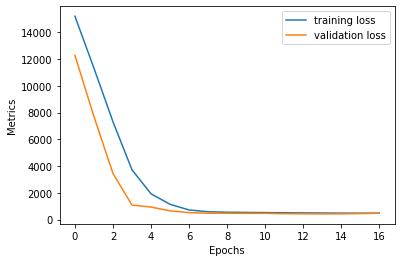

MODEL FIT SUCCESFULLY !! ??
Debugging shapes          (59,)          (59,)          [861   1]          (920,)
Debugging shapes
Imputed values (59, 1)
Target null (59, 1)
Non null targets (861, 1)
Full target vector (920, 1)
Non null target vector (861, 1)
FIRST ONE WORKED!!!
SECOND ONE WORKED!!!
Shape of resultant tensor (920, 23)
Column is region. Count of nulls in column is 62
Feature columns are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 24, 18, 20, 22, 21]
Nulls in target = (62, 1). Should equal 62.
Nulls in training = (62, 1, 23). Should equal 62.
Target non_nulls = (858, 1). Correct shape.
Training non_nulls = (858, 1, 23). Correct shape.
non_null_training shape post squeeze = (858, 23)
non_null_target shape post squeeze = (858,).
null_training shape post squeeze = (62, 23).
null_target shape post squeeze = (62,).
Therefore type is continuous
Available data = dict_keys(['loss', 'val_loss'])


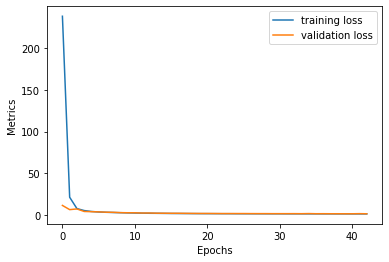

MODEL FIT SUCCESFULLY !! ??
Debugging shapes          (62,)          (62,)          [858   1]          (920,)
Debugging shapes
Imputed values (62, 1)
Target null (62, 1)
Non null targets (858, 1)
Full target vector (920, 1)
Non null target vector (858, 1)
FIRST ONE WORKED!!!
SECOND ONE WORKED!!!
Shape of resultant tensor (920, 24)
Column is region. Count of nulls in column is 90
Feature columns are [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 24, 18, 20, 22, 21, 19]
Nulls in target = (90, 1). Should equal 90.
Nulls in training = (90, 1, 24). Should equal 90.
Target non_nulls = (830, 1). Correct shape.
Training non_nulls = (830, 1, 24). Correct shape.
non_null_training shape post squeeze = (830, 24)
non_null_target shape post squeeze = (830,).
null_training shape post squeeze = (90, 24).
null_target shape post squeeze = (90,).
Therefore type is binary
Available data = dict_keys(['loss', 'val_loss'])


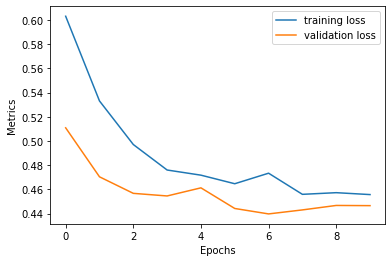

MODEL FIT SUCCESFULLY !! ??
Debugging shapes          (90,)          (90,)          [830   1]          (920,)
Debugging shapes
Imputed values (90, 1)
Target null (90, 1)
Non null targets (830, 1)
Full target vector (920, 1)
Non null target vector (830, 1)
FIRST ONE WORKED!!!
SECOND ONE WORKED!!!
Shape of resultant tensor (920, 25)


In [ ]:
#@title Default title text
# Still need to split into training and test set to see how accurate your imputation is.
# Define a function for each individual iteration then loop over it. 
# Much tidier approach

for num, (target_column, count) in enumerate(columns_ordered):
  """ Need to train on all of the non-nulls and predict the nulls. 
  Need to get the row index of the nulls and use that to slice the rest of the 
  tensor and that defines your training set. Need tf.where
  """
  print(f'Column is {column}. Count of nulls in column is {count}')
  print(f'Feature columns are {feature_columns}')
  if num == 0:
    train_tensor = tf.gather(complete_tensor, feature_columns, axis=1)
  else:
    pass

  # Lots of replicate indices are defined below
  # It should be the same single index for all of them with/without ~ (I think)
  target_vector = tf.gather(complete_tensor, target_column, axis=1)
  null_target_idx = tf.where(tf.math.is_nan(target_vector))
  null_target = tf.gather(target_vector, null_target_idx)
  print(f'Nulls in target = {null_target.shape}. Should equal {count}.')

  null_training = tf.gather(train_tensor, null_target_idx, axis=0)
  print(f'Nulls in training = {null_training.shape}. Should equal {count}.')

  # have to split this into train and test datasets and then predict on the nulls
  non_null_target_idx = tf.where(~tf.math.is_nan(target_vector))
  non_null_target = tf.gather(target_vector, non_null_target_idx)
  print(f'Target non_nulls = {non_null_target.shape}. Correct shape.')

  # Need to broadcast this accross all of the feature columns. 
  # Can set the axis of some other function
  non_null_training_idx = tf.where(~tf.math.is_nan(target_vector))
  non_null_training = tf.gather(train_tensor, non_null_training_idx, axis=0)
  print(f'Training non_nulls = {non_null_training.shape}. Correct shape.')

  # Should remove any 1 value deep dimensions
  non_null_training = tf.squeeze(non_null_training)
  non_null_target = tf.squeeze(non_null_target)
  null_training = tf.squeeze(null_training)
  null_target = tf.squeeze(null_target)
  print(f'non_null_training shape post squeeze = {non_null_training.shape}')
  print(f'non_null_target shape post squeeze = {non_null_target.shape}.')
  print(f'null_training shape post squeeze = {null_training.shape}.')
  print(f'null_target shape post squeeze = {null_target.shape}.')

  #print(f'Unique values of target are {tf.unique(non_null_target)[0]}')
  if len(tf.unique(non_null_target)[0]) > 2:
    target_type = 'continuous'
  if len(tf.unique(non_null_target)[0]) == 2:
    target_type = 'binary'

  print(f'Therefore type is {target_type}')

  model = build_and_compile_model(target_type)

  epochs = 50
  history = model.fit(non_null_training, 
                      non_null_target, 
                      validation_split=0.2, 
                      epochs=epochs,
                      verbose=0,
                      callbacks = [custom_early_stopping]
                                   #model_checkpoint_callback]
                      )
  plot_learning(history, epochs)

  print('MODEL FIT SUCCESFULLY !! ??')
  # Then have to set the previous nulls to these imputed values.

  #print(f'Values before imputation = {null_target}.')
  if target_type == 'binary':
    imputed_values = model.predict_classes(null_training)
  
  if target_type == 'continuous':
    imputed_values = model.predict(null_training)
  
  #print(f'Values after imputation = {imputed_values}.  \
  #        Shape is {imputed_values.shape}')
  

  # Setting previous nulls to imputed values (target_null_idx already exists)
  # Only gets row number, need to use target_column for column number
  # https://stackoverflow.com/questions/44657388/how-to-replace-certain-values-in-tensorflow-tensor-with-the-values-of-the-other
 
  target_null_boolean = tf.math.is_nan(target_vector)
  target_null_idx = tf.where(target_null_boolean)
  #print(target_null_idx) # use this to fill in the imputed values

  imputed_values_ints = tf.squeeze(tf.cast(imputed_values, tf.int64))
  #print(f'Did conversion to integers actually work? {imputed_values_ints}')
  target_null_idx = tf.squeeze(tf.cast(target_null_idx, tf.int64))
  target_vector = tf.cast(target_vector, tf.int64)

  print(f'Debugging shapes \
         {imputed_values_ints.shape} \
         {target_null_idx.shape} \
         {tf.squeeze(non_null_target_idx.shape)} \
         {target_vector.shape}')

  # Gather then Scatter?

  imputed_values_ints = tf.expand_dims(imputed_values_ints, axis=1)
  target_vector = tf.expand_dims(target_vector, axis=1)
  target_null_idx = tf.expand_dims(target_null_idx, axis=1)
  non_null_target = tf.expand_dims(non_null_target, axis=1)

  print(f'Debugging shapes')
  print(f'Imputed values {imputed_values_ints.shape}')
  print(f'Target null {target_null_idx.shape}')
  print(f'Non null targets {non_null_target_idx.shape}')
  print(f'Full target vector {target_vector.shape}') 
  print(f'Non null target vector {non_null_target.shape}') 


  # Scatter both and then add them together
  updates = tf.scatter_nd(
              target_null_idx, imputed_values_ints, target_vector.shape
            )
  
  print('FIRST ONE WORKED!!!')

  # target_vector will be too large. 
  base = tf.scatter_nd(
              non_null_target_idx, non_null_target, target_vector.shape
            )
  
  print('SECOND ONE WORKED!!!')
  
  target_vector = tf.cast(base, tf.float32) + tf.cast(updates, tf.float32)

  # Add to tensor
  train_tensor = tf.concat([train_tensor,target_vector], axis = 1)

  print(f'Shape of resultant tensor {train_tensor.shape}')

  # # After imputation add the feature to the list of features to use as training
  feature_columns.append(target_column)

In [ ]:
# Print number of nulls by column (should be 0 for all)
null_indices = tf.where(tf.math.is_nan(train_tensor))
# Need to count by column (second number)
value, idx, number_nulls = tf.unique_with_counts(null_indices[:,1])
print(number_nulls) # Think the fact that it's empty means that you don't have any left!!!

tf.Tensor([], shape=(0,), dtype=int32)


## Complete the exercise by using the training_tensor to predict the num target var!

For the sake of comparison start off with the same simplification you used on previous exercise turn it into a binary classification task

In [ ]:
# rows with null target tensor already removed
target_tf_simple = tf.map_fn(lambda x: 1 if x != 0 else 0, target_tf)

Xtrain shape is (736, 25)
ytrain shape is (736,)
Available data = dict_keys(['loss', 'val_loss'])


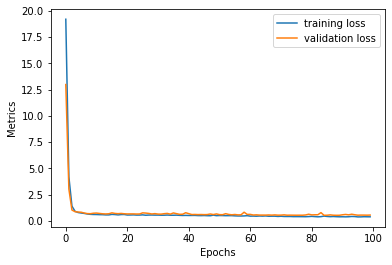

In [ ]:
model = build_and_compile_model('binary', 'complex')


X1, X2, X3, X4, Xtest = tf.split(train_tensor, num_or_size_splits=5, axis=0)
Xtrain = tf.concat([X1,X2,X3,X4],axis=0)
print(f'Xtrain shape is {Xtrain.shape}')

y1, y2, y3, y4, ytest = tf.split(target_tf_simple, num_or_size_splits=5, axis=0)
ytrain = tf.concat([y1,y2,y3,y4], axis=0)
print(f'ytrain shape is {ytrain.shape}')

history = model.fit(Xtrain, 
                    ytrain, 
                    validation_split=0.2, 
                    epochs=100,
                    verbose=0
                    #callbacks = [custom_early_stopping]
                                  #model_checkpoint_callback]
                    )

plot_learning(history, epochs)

ypred = model.predict_classes(Xtest)

In [ ]:
actual, predicted = tf.cast(ytest, tf.int32), tf.cast(tf.squeeze(ypred), tf.int32)

TP = tf.math.count_nonzero(predicted * actual)
TN = tf.math.count_nonzero((predicted - 1) * (actual - 1))
FP = tf.math.count_nonzero(predicted * (actual - 1))
FN = tf.math.count_nonzero((predicted - 1) * actual)

confusion_matrix = [[TN.numpy(), FP.numpy()],
                    [FN.numpy(), TP.numpy()]]

print(f'Confusion matrix is {confusion_matrix}')

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)

print(f'F1 score after all this work is {f1}')

Confusion matrix is [[67, 31], [18, 68]]
F1 score after all this work is 0.735135135135135
